**ARIMA, SARIMA and SARIMAX**

[Source](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

Forecasting a time series can be broadly divided into two types.

1. If you use only the previous values of the time series to predict its future values, it is called *Univariate* Time Series Forecasting.

2. And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called *Multi Variate* Time Series Forecasting.

## ARIMA(p, d, q)

* `p` is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors.
* `d` is the minimum number of differencing needed to make the series stationary.
* `q` is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

Predicted $Y_t$ = Constant + Linear combination of Lags of Y (upto $p$ lags) + Linear combination of Lagged forecat errors (upto $q$ lags) 

#### Find the order of differencing (`d`)

The purpose of differencing it to make the time series stationary.

* Check if the series is stationary using the Augmented Dickey Fuller test (`adfuller()`).  
* If the p-value of the test is less than the significance level (0.05) then infer that the time series is indeed stationary.

In [12]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('data/wwwusage.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.head(3)

,time,value
0,1,88
1,2,84
2,3,85


In [14]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Time series is not stationary

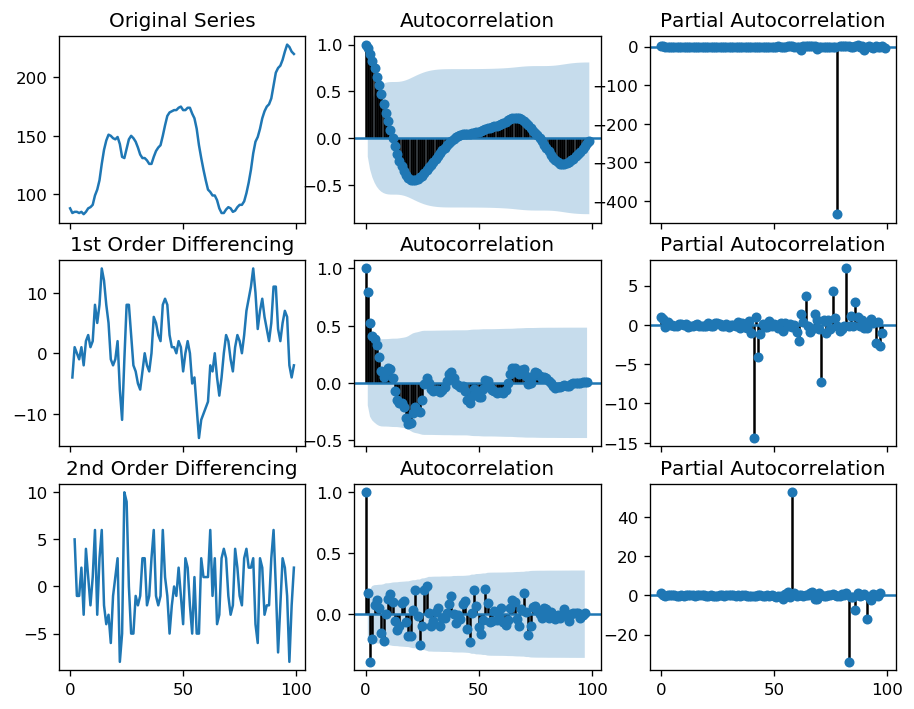

In [31]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])
plot_pacf(df.value, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])
plot_pacf(df.value.diff().dropna(), ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df.value.diff().diff().dropna(), ax=axes[2, 2])
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

In [17]:
from pmdarima.arima.utils import ndiffs

y = df['value'].copy()

## Adf Test
print(ndiffs(y, test='adf'))  

# KPSS test
print(ndiffs(y, test='kpss'))  

# PP test:
print(ndiffs(y, test='pp')) 

2
0
2


#### Finding the order of the AR term (`p`)

Partial Autocorrelation plot (PACF) sort of conveys the pure correlation between a lag and the series.

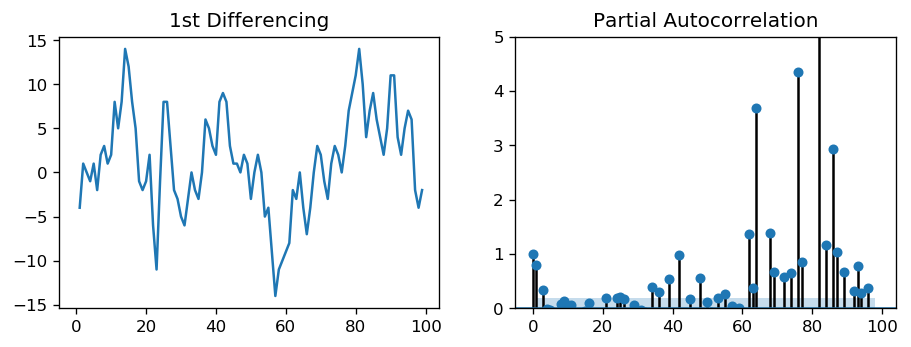

In [19]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

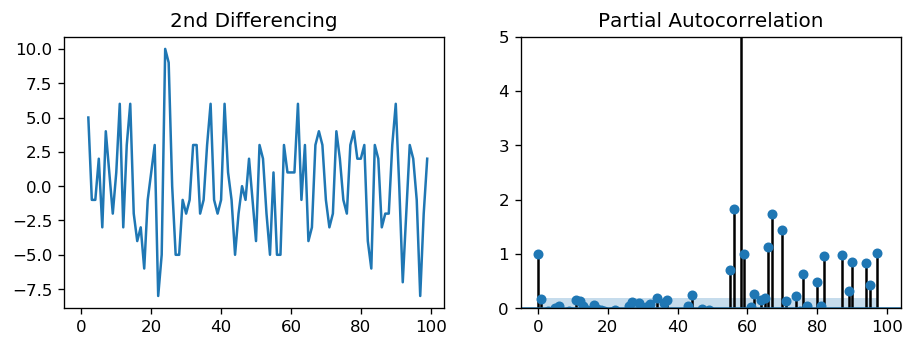

In [23]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().diff().dropna(), ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

#### Finding the order of the MA term (`q`)

You can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

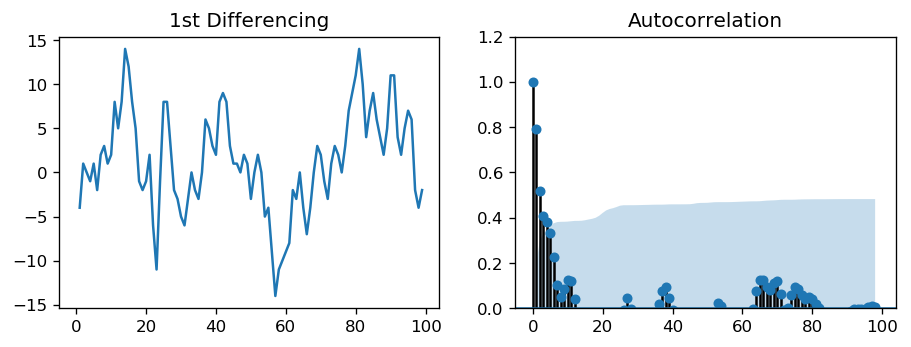

In [24]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

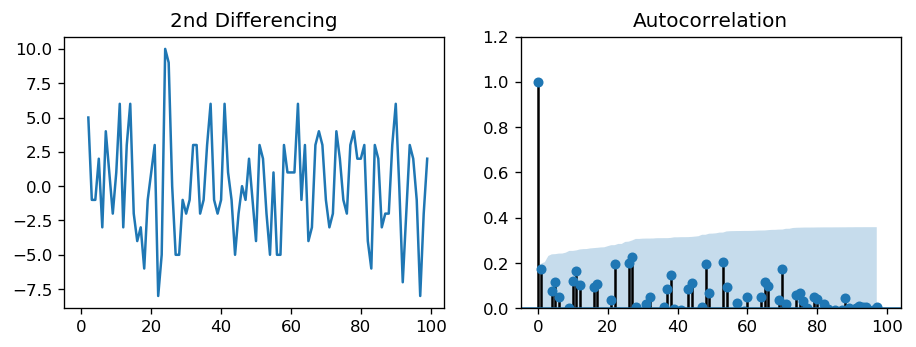

In [26]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().diff().dropna(), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

**If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.**

### Build the ARIMA model

In [32]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Sun, 03 Mar 2019   AIC                            517.579
Time:                        14:14:49   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.387      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.015       0.131       1.139
ma.L1.D.value     0.5287      0.355     

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.

In [33]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Sun, 03 Mar 2019   AIC                            515.579
Time:                        14:16:14   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.386      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

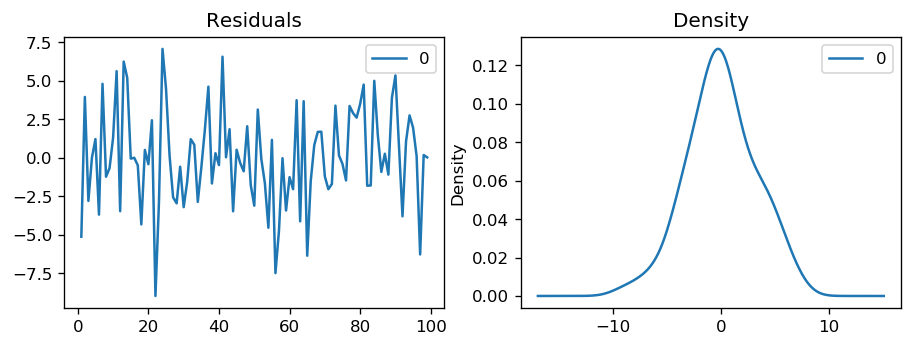

In [38]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using `plot_predict()`.

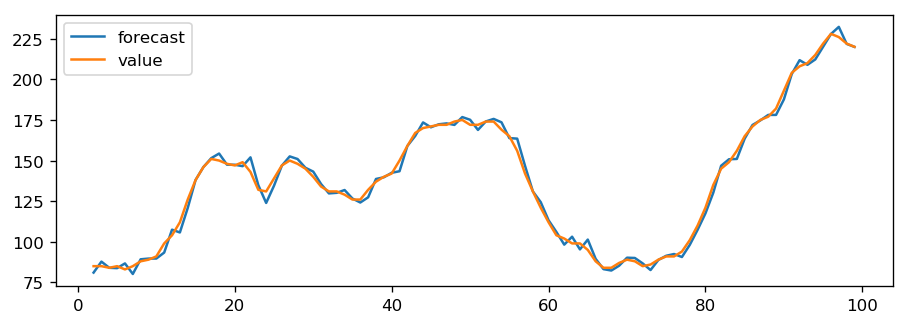

In [39]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

When you set `dynamic=False` the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

### Finding the optimal ARIMA model manually using Out-of-Time Cross validation

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

In [42]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

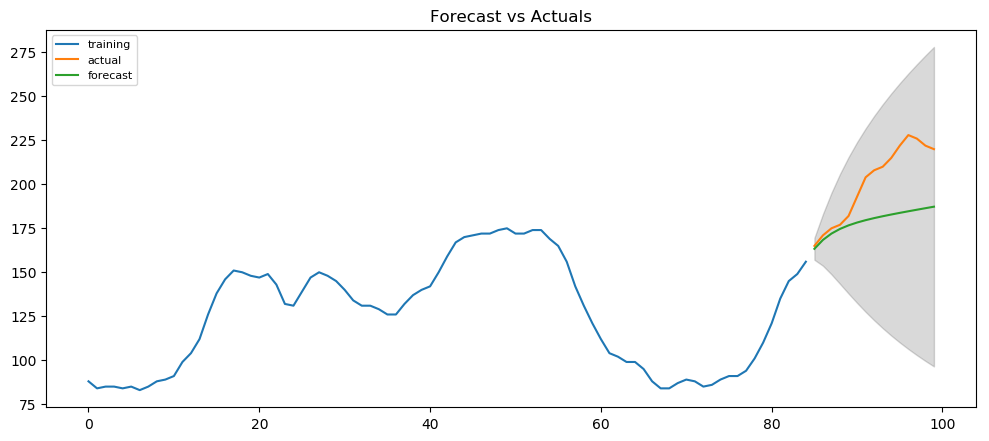

In [43]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Sun, 03 Mar 2019   AIC                            440.497
Time:                        14:22:08   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.565      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

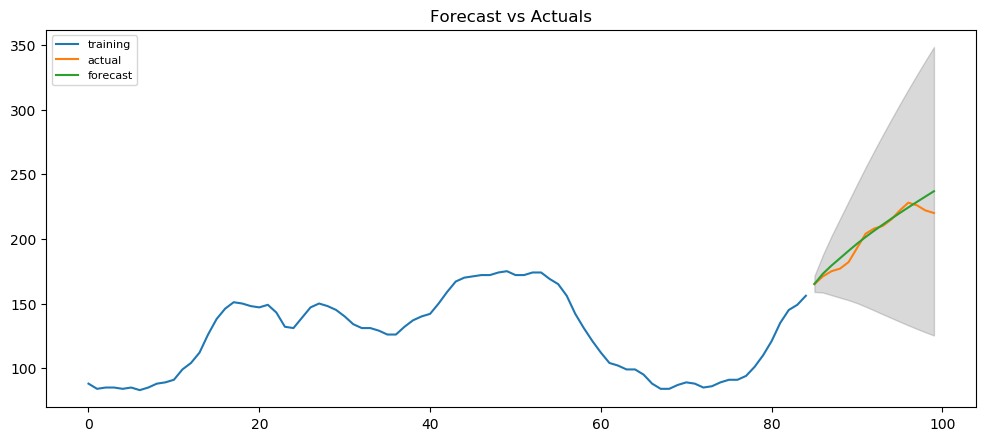

In [44]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

### Accuracy Metrics

In [45]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.022501305114356305,
 'me': 3.2307774659756165,
 'mae': 4.548320385364536,
 'mpe': 0.016420975902695575,
 'rmse': 6.373234889679405,
 'acf1': 0.5105507587572337,
 'corr': 0.9674576520337695,
 'minmax': 0.02163154042918869}

Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.

## Auto ARIMA forecast

In [46]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df.value, 
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 2, 1); AIC=525.586, BIC=535.926, Fit time=0.098 seconds
Fit ARIMA: order=(0, 2, 0); AIC=533.474, BIC=538.644, Fit time=0.016 seconds
Fit ARIMA: order=(1, 2, 0); AIC=532.437, BIC=540.192, Fit time=0.029 seconds
Fit ARIMA: order=(0, 2, 1); AIC=525.893, BIC=533.648, Fit time=0.022 seconds
Fit ARIMA: order=(2, 2, 1); AIC=515.248, BIC=528.173, Fit time=0.074 seconds
Fit ARIMA: order=(2, 2, 0); AIC=513.459, BIC=523.798, Fit time=0.032 seconds


/Users/adhiman/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/adhiman/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/adhiman/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

Fit ARIMA: order=(3, 2, 1); AIC=512.552, BIC=528.062, Fit time=0.235 seconds
Fit ARIMA: order=(3, 2, 0); AIC=515.284, BIC=528.209, Fit time=0.055 seconds
Fit ARIMA: order=(3, 2, 2); AIC=514.514, BIC=532.609, Fit time=0.258 seconds
Total fit time: 0.837 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   98
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -250.276
Method:                       css-mle   S.D. of innovations              3.069
Date:                Sun, 03 Mar 2019   AIC                            512.552
Time:                        14:26:52   BIC                            528.062
Sample:                             2   HQIC                           518.825
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

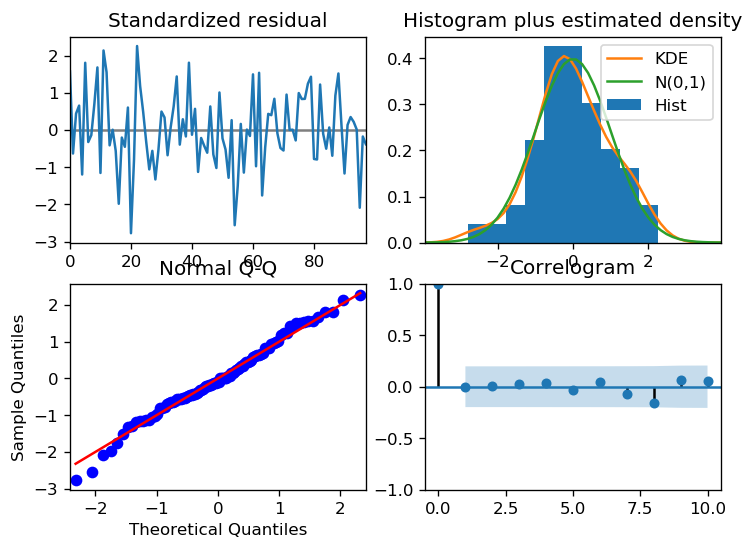

In [47]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

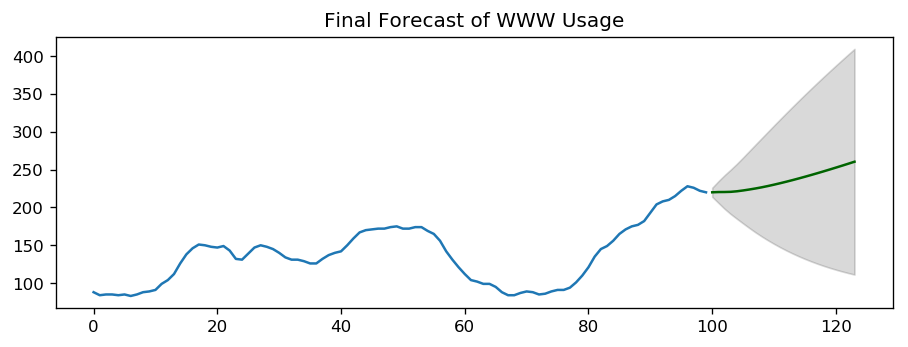

In [48]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

## Auto SARIMA

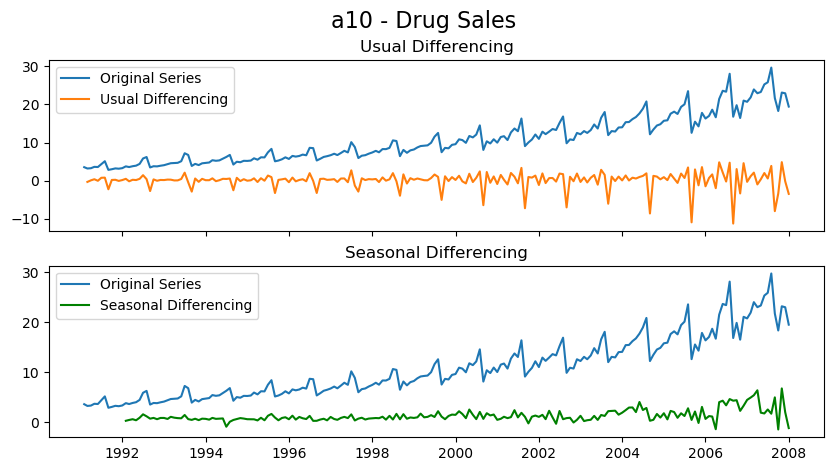

In [74]:
# Import
data = pd.read_csv('data/a10.csv')
data.drop(data.columns[0], axis=1, inplace=True)
data.set_index(pd.date_range(start='1/7/1991', end='1/6/2008', freq='MS'), inplace=True)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [77]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=534.818, BIC=551.105, Fit time=1.164 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=624.061, BIC=630.576, Fit time=0.032 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=596.004, BIC=609.034, Fit time=0.361 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=611.475, BIC=624.505, Fit time=0.255 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=557.553, BIC=577.098, Fit time=1.592 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=559.407, BIC=572.437, Fit time=0.225 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=536.817, BIC=556.362, Fit time=2.954 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=529.829, BIC=549.374, Fit time=1.999 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12);

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -258.300
Date:                            Sun, 03 Mar 2019   AIC                            528.601
Time:                                    14:44:05   BIC                            548.146
Sample:                                         0   HQIC                           536.517
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1649      0.097      1.705      0.088      -0.025       0.354
ar.L1          0.0949      0.043      2.205      0.027       0.011       0.179
ar.L2          0.4145      0.035     11.907      0.000       0.346       0.483
ar.L3          0.3531      0.053      6.601      0.000       0.248       0.458
ma.S.L12      -0.4635      0.058     -8.008      0.000      -0.577      -0.350
sigma2         0.8461      0.057     14.925      0.000       0.735       0.957
===================================================================================
Ljung-Box (Q):                       59.80   Jarque-Bera (JB):               124.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.75   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

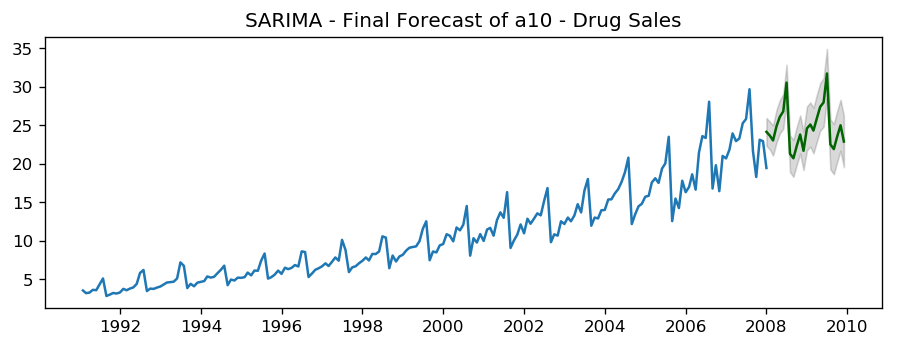

In [78]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

## SARIMAX Model with exogenous variable

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model.

In [80]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['x'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

In [83]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=536.818, BIC=556.362, Fit time=1.086 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=626.061, BIC=635.834, Fit time=0.034 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=598.004, BIC=614.292, Fit time=0.568 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=613.475, BIC=629.762, Fit time=0.311 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=559.518, BIC=582.321, Fit time=2.032 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=561.407, BIC=577.695, Fit time=0.305 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=538.817, BIC=561.620, Fit time=3.080 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=531.829, BIC=554.632, Fit time=0.994 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 12);

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -258.300
Date:                            Sun, 03 Mar 2019   AIC                            530.601
Time:                                    14:48:11   BIC                            553.403
Sample:                                         0   HQIC                           539.836
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1649      0.097      1.705      0.088      -0.025       0.354
x1          3.928e-07    2.4e-09    163.492      0.000    3.88e-07    3.97e-07
ar.L1          0.0949      0.043      2.205      0.027       0.011       0.179
ar.L2          0.4145      0.035     11.907      0.000       0.346       0.483
ar.L3          0.3531      0.053      6.601      0.000       0.248       0.458
ma.S.L12      -0.4635      0.058     -8.008      0.000      -0.577      -0.350
sigma2         0.8461      0.057     14.925      0.000       0.735       0.957
===================================================================================
Ljung-Box (Q):                       59.80   Jarque-Bera (JB):               124.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.75   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+17. Standard errors may be unstable.
"""

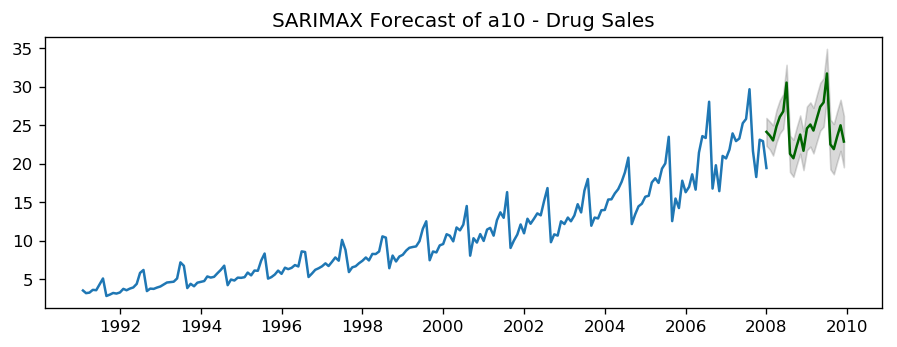

In [86]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.x, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['x'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()